# UPF 
## Quick Start
This notebook aims at showing how to use the UPF, NLS[[1]](#1), QCQP[[2]](#2) and ALgebraic[[3]](#3)  soluiton to solve the relative pose estimation problem in 3D (4-dof).  

The note is divided into the following sections:
1. Create drone simulation  
2. The UPF
3. NLS
4. QCQP
5. Algebraic
6. Running analysis
7. Running in ROS environment

### References
<a id="1">[1]</a> 
T. Ziegler, M. Karrer, P. Schmuck, and M. Chli, “Distributed formation
estimation via pairwise distance measurements,” IEEE Robotics and
Automation Letters, vol. 6, no. 2, pp. 3017–3024, 2021

<a id="2">[2]</a> 
T. H. Nguyen and L. Xie, “Relative transformation estimation based
on fusion of odometry and uwb ranging data,” IEEE Transactions on
Robotics, pp. 1–17, 2023.

<a id="3">[3]</a> 
N. Trawny, X. S. Zhou, K. Zhou, and S. I. Roumeliotis, “Interrobot
transformations in 3-d,” IEEE Transactions on Robotics, vol. 26, no. 2,
pp. 226–243, 2010.

### Create drone simulation 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Code.Simulation.BiRobotMovement import drone_flight, run_simulation, random_movements_host_random_movements_connected
from Code.UtilityCode.utility_fuctions import sphericalToCartesian

#set parameters
simulation_time = 300
odom_frequency = 10.
odom_time_step = 1/odom_frequency
uwb_frequency = 10.
factor = odom_frequency/uwb_frequency
simulation_time_steps = int(simulation_time / odom_time_step) 

max_range = 5
sigma_v =  0.01
sigma_w = 0.01
sigma_uwb = 0.1


# Created randomised starting positions.
x_drone_0 = sphericalToCartesian(np.array([np.random.uniform(0,max_range), np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi)]))
pose_drone_0 = np.concatenate((x_drone_0, np.array([np.random.uniform(0, 2*np.pi)])))
x_drone_1 = sphericalToCartesian(np.array([np.random.uniform(0,max_range), np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi)]))
pose_drone_1 = np.concatenate((x_drone_1, np.array([np.random.uniform(0, 2*np.pi)])))
# print(pose_drone_0, pose_drone_1)

drone_0 = drone_flight(pose_drone_0, sigma_dv=sigma_v, sigma_dw=sigma_w, max_range=max_range,
                          origin_bool=True, simulation_time_step=odom_time_step)
drone_1 = drone_flight(pose_drone_1, sigma_dv=sigma_v, sigma_dw=sigma_w, max_range=max_range,
                         origin_bool=True, simulation_time_step=odom_time_step)

run_simulation(simulation_time_steps, drone_0, drone_1,
                       random_movements_host_random_movements_connected)

distances = np.linalg.norm(drone_0.x_real - drone_1.x_real, axis=1) + np.random.randn(simulation_time_steps+1) * sigma_uwb
startMeasurement = distances[0] 

[-2.09512358 -3.36245739  2.32487847  2.38170588] [-2.01874862  0.27459046  4.22948409  4.6245809 ]
{}


### Plotting the simulated trajectory

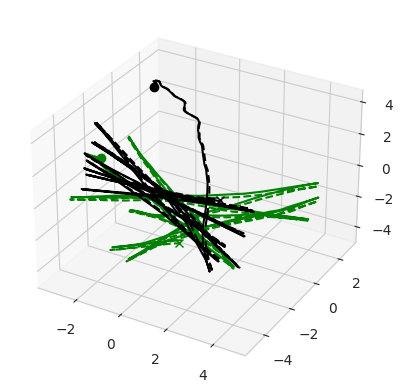

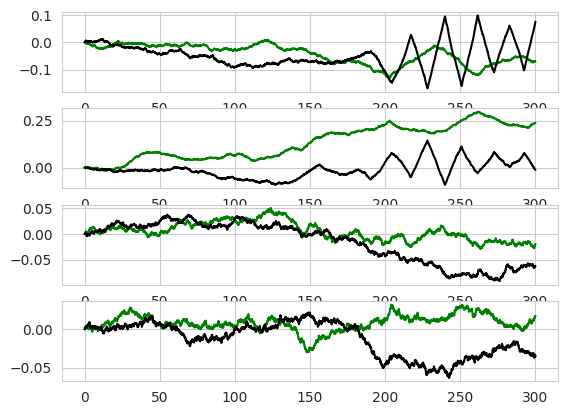

In [2]:
ax = plt.figure().add_subplot(projection='3d')
drone_0.plot_trajectory(ax =ax, color = "green")
drone_0.plot_slam_position(ax =ax, color = "green", linestyle="--")
drone_1.plot_trajectory(ax =ax, color = "black")
drone_1.plot_slam_position(ax =ax, color = "black", linestyle="--")

ax = drone_0.plot_slam_error(annotation="Drone_0", color ="green")
ax = drone_1.plot_slam_error(annotation="Drone_1", ax=ax, color="black")
#TODO: add legends
plt.show()

### The UPF
#### Setting up the UPF

In [3]:
from Code.ParticleFilter.ConnectedAgentClass import UPFConnectedAgent
from Code.DataLoggers.ConnectedAgent_DataLogger import UPFConnectedAgentDataLogger

upf0 = UPFConnectedAgent(id="drone_1", x_ha_0=pose_drone_0, drift_correction_bool=True, resample_factor=0.1)
upf0.set_ukf_parameters(kappa=-1, alpha=1, beta=2)
upf0.split_sphere_in_equal_areas(r=distances[0], sigma_uwb= sigma_uwb, n_azimuth=4, n_altitude=3, n_heading=4)

dl0 = UPFConnectedAgentDataLogger(drone_0, drone_1, upf0)

#### Running the UPF simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


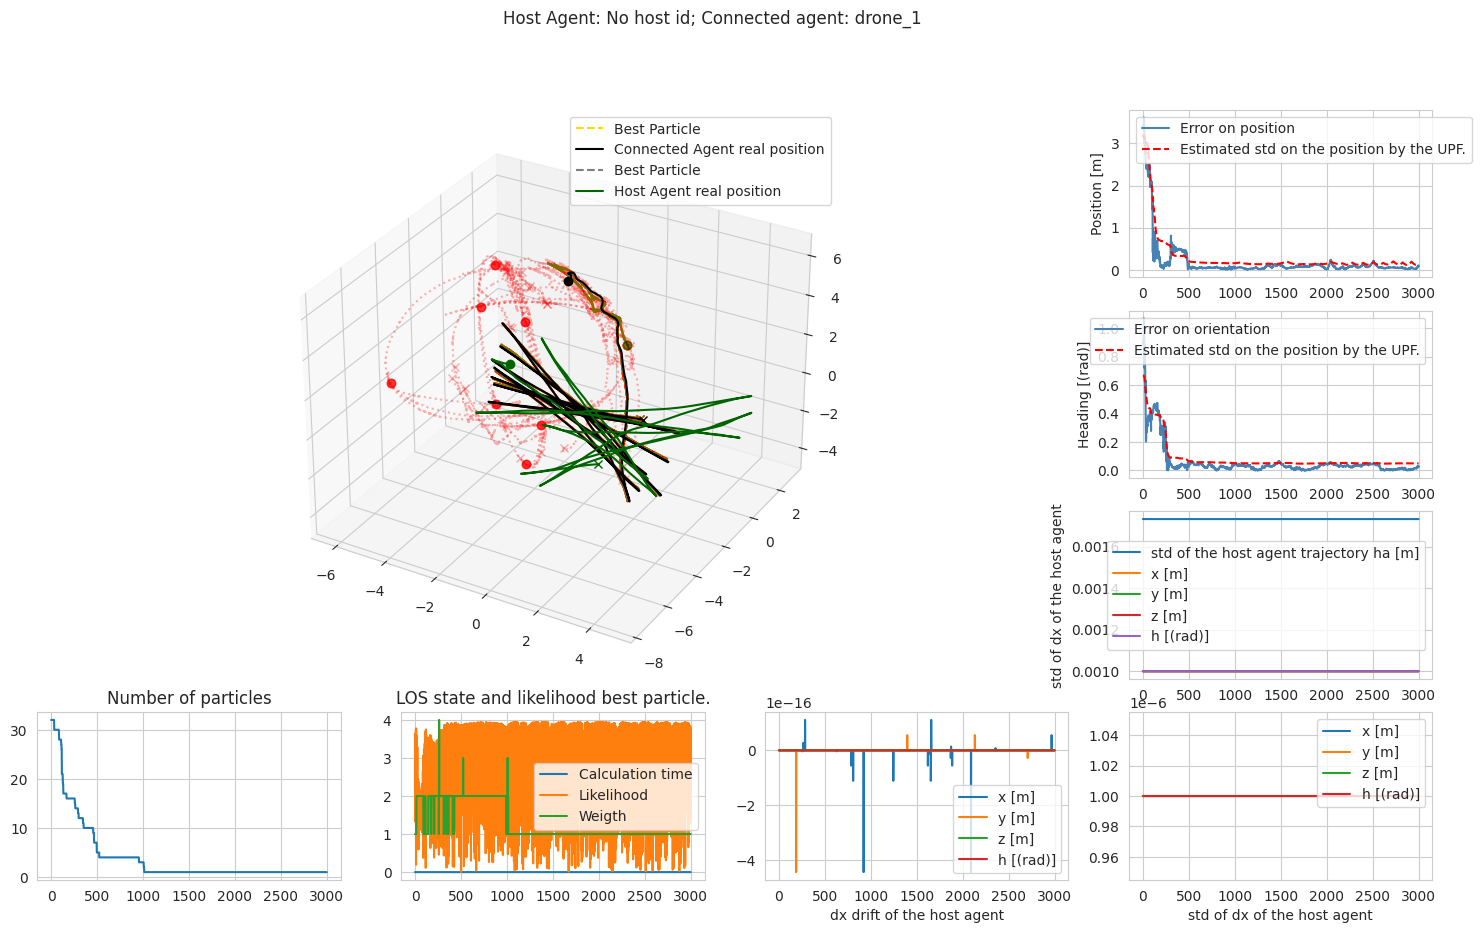

In [4]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps+1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    d_dx_0 = np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    upf0.ha.predict(d_dx_0, drone_0.q)
    q_0 = q_0 + get_4d_rot_matrix(drone_0.h_slam[i]) @ drone_0.q @ get_4d_rot_matrix(drone_0.h_slam[i]).T
    
    d_dx_1 = np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    f = get_4d_rot_matrix(d_dx_1[-1])
    dx_1 = dx_1 + f @ d_dx_1
    q_1 = q_1 + f @ drone_1.q @ f.T
    if i % factor == 0:
        x_ha = drone_0.x_slam[i]
        h_ha = drone_0.h_slam[i]
        x_ha = np.concatenate([x_ha, np.array([h_ha])])
        
        upf0.ha.update(x_ha, q_0)
        upf0.run_model(dx_1, distances[i], q_ca=q_1)
        dl0.log_data(i)
        
        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        q_0 = np.zeros((4, 4))
        upf0.ha.reset_integration()
 
#TODO: add legend       
dl0.plot_self()
plt.pause(0.01)
plt.close()

### NLS 
#### Setting up the NLS

In [5]:
from Code.BaseLines.NLS import NLS
from Code.DataLoggers.NLS_DataLogger import NLSDataLogger

agents = {"drone_0": drone_0, "drone_1": drone_1}
NLS = NLS(agents, horizon = 10, sigma_uwb=sigma_uwb)
sampling_factor = 10
nls_logger = NLSDataLogger(NLS)
NLS.init_logging(nls_logger)

#### Running the NLS simulation

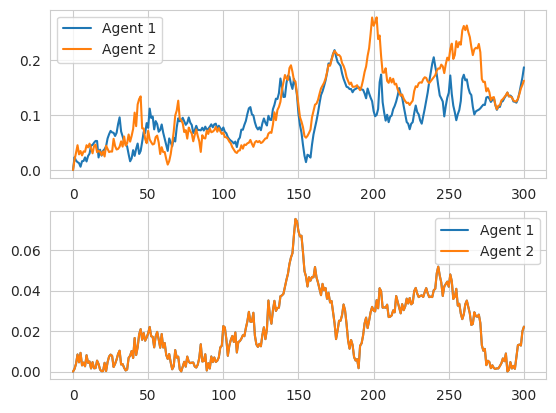

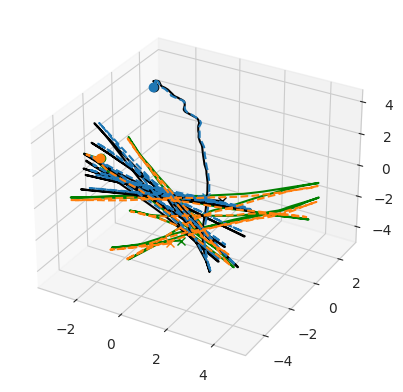

In [6]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor*sampling_factor) == 0:
        dx = np.vstack([dx_0.reshape(1, *dx_0.shape), dx_1.reshape(1, *dx_1.shape)])
        q_odom = np.vstack([q_0.reshape(1, *q_0.shape), q_1.reshape(1, *q_1.shape)])
        d = distances[i]
        d = np.array([[0, d], [0, 0]])
        NLS.update(d, dx, q_odom)

        nls_logger.log_data(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))

nls_logger.plot_self()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
NLS.agents[0].set_plotting_settings(color="green")
NLS.agents[0].plot_real_position(ax)
NLS.agents[1].set_plotting_settings(color="black")
NLS.agents[1].plot_real_position(ax)
nls_logger.plot_corrected_estimated_trajectory(ax, color="tab:blue", linestyle="--")
nls_logger.plot_corrected_estimated_trajectory(ax, agent=1, color="tab:orange", linestyle="--")
#TODO: add legend and labels

plt.show()

### QCQP
It is important to note you need a Gurboi license to run this code.
#### Setting up the QCQP

In [13]:
from Code.BaseLines.QCQP import QCQP
from Code.DataLoggers.QCQP_DataLogger import QCQP_Log

qcqp = QCQP(horizon=500,  sigma_uwb=sigma_uwb)
qcqp_log = QCQP_Log(qcqp, drone_0, drone_1)

#### Running the QCQP simulation

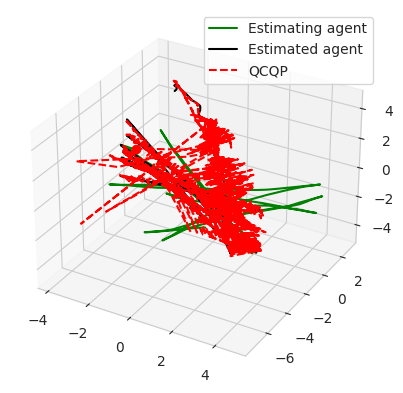

In [14]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps+1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor) == 0:
        qcqp.update(dx_0, dx_1, distances[i])
        qcqp_log.log(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
drone_0.plot_trajectory(ax= ax, color="green", label="Estimating agent")
drone_1.plot_trajectory(ax= ax, color="k", label="Estimated agent")
qcqp_log.plot_corrected_estimated_trajectory(ax=ax, color="r", linestyle=":", marker="", label="QCQP")
plt.legend()
plt.show()


### Algebraic


#### Setting up the Algebraic method

In [9]:
from Code.BaseLines.AlgebraicMethod4DoF import AlgebraicMethod4DoF
from Code.BaseLines.AlgebraicMethod4DoF import Algebraic4DoF_Logger

AM0 = AlgebraicMethod4DoF(distances[0], sigma_uwb=sigma_uwb, x_ha=pose_drone_0)
AM0.horizon = 100
alg_log = Algebraic4DoF_Logger(alg_solver=AM0, host=drone_0, connect=drone_1)

#### Running the Algebraic method simulation

/home/yuri/Documents/PhD/ROS_WS/sharedDrive/CodeBase/UPF_old/UPF_RPE/Code/BaseLines/AlgebraicMethod4DoF.py:177: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(Mat, eps)[0]
/home/yuri/Documents/PhD/ROS_WS/sharedDrive/CodeBase/UPF_old/UPF_RPE/Code/BaseLines/AlgebraicMethod4DoF.py:181: RuntimeWarning: invalid value encountered in arccos
  x = np.concatenate((np.squeeze(x[3:6]), np.array(2 * np.arccos(np.sqrt(x[2])))))
/home/yuri/Documents/PhD/ROS_WS/sharedDrive/CodeBase/UPF_old/UPF_RPE/Code/BaseLines/AlgebraicMethod4DoF.py:181: RuntimeWarning: invalid value encountered in sqrt
  x = np.concatenate((np.squeeze(x[3:6]), np.array(2 * np.arccos(np.sqrt(x[2])))))


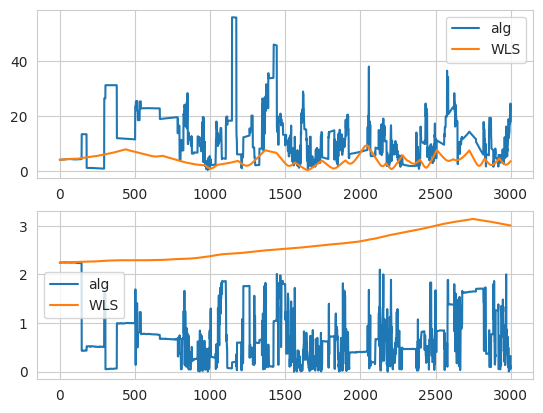

In [10]:
from Code.UtilityCode.utility_fuctions import get_4d_rot_matrix
import numpy as np
import matplotlib.pyplot as plt

dx_1 = np.zeros(4)
q_1 = np.zeros((4, 4))
dx_0 = np.zeros(4)
q_0 = np.zeros((4, 4))
for i in range(1, simulation_time_steps + 1):
    # print("Simulation step: ", i, " /", simulation_time_steps)
    c_1 = get_4d_rot_matrix(dx_1[-1])
    dx_1 = dx_1 + c_1 @ np.concatenate((drone_1.dx_slam[i], np.array([drone_1.dh_slam[i]])))
    q_1 = q_1 + c_1 @ drone_1.q @ c_1.T

    c_0 = get_4d_rot_matrix(dx_0[-1])
    dx_0 = dx_0 + c_0 @ np.concatenate((drone_0.dx_slam[i], np.array([drone_0.dh_slam[i]])))
    q_0 = q_0 + c_0 @ drone_0.q @ c_0.T

    if i % (factor) == 0:
        d = distances[i]
        AM0.get_update(d=d, dx_ha=dx_0, dx_ca=dx_1, q_ha=q_0, q_ca=q_1)

        alg_log.log(i)

        dx_1 = np.zeros(4)
        q_1 = np.zeros((4, 4))
        dx_0 = np.zeros(4)
        q_0 = np.zeros((4, 4))

# , ax = plt.subplots(2, 1)

alg_log.plot_self()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# drone_0.plot_trajectory(ax=ax, color="green", label="Estimating agent")
# drone_1.plot_trajectory(ax=ax, color="k", label="Estimated agent")
# # self.drone.plot_slam_position(ax=ax, color="k", linestyle="--")
# # self.host.plot_slam_position(ax=ax, color="green", linestyle="--")
# qcqp_log.plot_corrected_estimated_trajectory(ax=ax, color="r", linestyle="--", marker="", label="QCQP")
# plt.legend()
plt.show()


### Running analysis

## Running in ROS environment